In [65]:
# importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler


In [66]:
df = pd.read_csv("output_file.csv")

df.head()

,id,title,link,content,gold_label
0,0,ٹرمپ کے متنازع احکامات پر کیا ردعمل دینا ہے؟ پ...,https://urdu.geo.tv/latest/386198-,امریکی وزارت دفاع پینٹاگون کے عہدیداران میں ...,world
1,1,انسانی روبوٹ کا پہلا فن پارہ 30کروڑ روپے میں ن...,https://urdu.geo.tv/latest/386187-,ایک انسان نما روبوٹ نے ایک انگریز ریاضی دان ...,world
2,2,غزہ: مسلسل اسرائیلی بمباری سے گزشتہ 24 گھنٹوں ...,https://urdu.geo.tv/latest/386167-,غزہ میں مسلسل اسرائیلی بمباری سے گزشتہ گھنٹ...,world
3,3,امریکا نے قطر سے حماس قیادت کو ملک بدر کرنے کا...,https://urdu.geo.tv/latest/386165-,امریکا نے اسرائیلی یرغمالیوں کی رہائی سے متع...,world
4,4,امریکی مسلمان اور عرب ووٹرز کے ڈیموکریٹک پارٹی...,https://urdu.geo.tv/latest/386163-,امریکا کی سب سے بڑی مسلم شہری حقوق اور وکالت...,world


In [67]:
# defined some stopwords manually to remove them
urdu_stopwords = [
    "کی","اس","کے", "ہے", "اور", "میں", "سے", "کو", "کا", "کر", "یہ", "نے", "تو", "پر", "بھی",
]

def remove_stopwords(text, stopwords_list):
    if not isinstance(text, str):
        return text
    words = text.split()  
    filtered_words = [word for word in words if word not in stopwords_list] 
    return " ".join(filtered_words)

In [68]:
#preprocessing
df['cleaned_content'] = df['content'].fillna("").apply(lambda x: " ".join([word for word in x.split() if word not in urdu_stopwords]))

In [69]:
#manual implementation of logistic regression
class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iter=1000, regularization=0.01):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.regularization = regularization
        self.weights = None
        self.bias = 0

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def cross_entropy_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15) #wanted to avoid log(0) errors
        loss = -(1 / m) * (np.dot(y_true, np.log(y_pred)) + np.dot(1 - y_true, np.log(1 - y_pred)))
        reg = (self.regularization / (2 * m)) * np.sum(np.square(self.weights))
        return loss + reg

    def fit(self, x_train, y_train):
        m, n = x_train.shape
        self.weights = np.zeros(n)
        self.bias = 0
        costs = []

        for _ in range(self.num_iter):
            linear_model = np.dot(x_train, self.weights) + self.bias
            y_pred = self.sigmoid(linear_model)

            gradient_weight = (1 / m) * np.dot(x_train.T, (y_pred - y_train)) + (self.regularization / m) * self.weights
            gradient_bias = (1 / m) * np.sum(y_pred - y_train)

            self.weights -= self.learning_rate * gradient_weight
            self.bias -= self.learning_rate * gradient_bias

            loss = self.cross_entropy_loss(y_train, y_pred)
            costs.append(loss)

        return costs

    def predict(self, x_test):
        linear_model = np.dot(x_test, self.weights) + self.bias
        y_pred_prob = self.sigmoid(linear_model)
        y_pred_class = [1 if i > 0.5 else 0 for i in y_pred_prob]
        return np.array(y_pred_prob), np.array(y_pred_class)

    def evaluate(self, y_true, y_pred):
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        conf_matrix = confusion_matrix(y_true, y_pred)
        return {
            "accuracy": accuracy,
            "f1_score": f1,
            "confusion_matrix": conf_matrix
        }


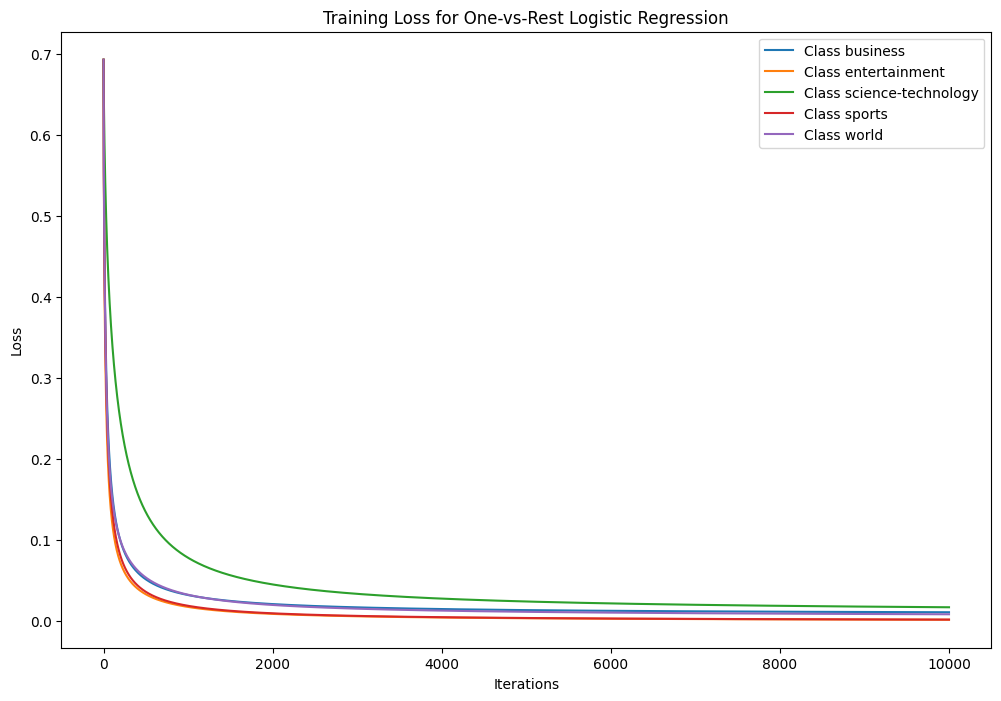

In [70]:
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['gold_label'])

vectorizer = TfidfVectorizer(max_features=1000)
features = vectorizer.fit_transform(df['cleaned_content']).toarray()
labels = df['encoded_label'].values

features_train, features_test, label_train, label_test = train_test_split(features, labels, test_size=0.2, random_state=42)

scaler = StandardScaler()
features_train_norm = scaler.fit_transform(features_train)
features_test_norm = scaler.transform(features_test)

classifiers = {}
losses = {}

for i in range(len(label_encoder.classes_)):
    y_binary = (label_train == i).astype(int)
    model = LogisticRegression(learning_rate=0.01, num_iter=10000, regularization=0.01)
    classifiers[i] = model
    cost = model.fit(features_train_norm, y_binary)
    losses[i] = cost

plt.figure(figsize=(12, 8))
for i in range(len(label_encoder.classes_)):
    plt.plot(losses[i], label=f'Class {label_encoder.classes_[i]}')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss for One-vs-Rest Logistic Regression')
plt.show()

In [71]:
results = {
    'Class': [],
    'Probs': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'Confusion Matrix': []
}

for i in range(len(label_encoder.classes_)):
    y_test_binary = (label_test == i).astype(int)
    probability, predicted_class = classifiers[i].predict(features_test_norm)
    evaluation_metrics = classifiers[i].evaluate(y_test_binary, predicted_class)
    results['Class'].append(label_encoder.classes_[i])
    results['Probs'].append(probability)
    results['Accuracy'].append(evaluation_metrics["accuracy"])
    results['Precision'].append(precision_score(y_test_binary, predicted_class))
    results['Recall'].append(recall_score(y_test_binary, predicted_class))
    results['F1 Score'].append(evaluation_metrics["f1_score"])
    results['Confusion Matrix'].append(evaluation_metrics["confusion_matrix"])

results_df = pd.DataFrame(results)

final_probs = np.array([results['Probs'][i] for i in range(len(label_encoder.classes_))]).T
final_predictions = np.argmax(final_probs, axis=1)

results_df.drop('Probs',axis=1)
results_df

,Class,Probs,Accuracy,Precision,Recall,F1 Score,Confusion Matrix
0,business,"[0.0010076583163793958, 0.00037553961907824194...",0.979522,0.941176,0.969697,0.955224,"[[223, 4], [2, 64]]"
1,entertainment,"[0.00037331776905092924, 0.0032714625417504394...",0.982935,0.966102,0.950000,0.957983,"[[231, 2], [3, 57]]"
2,science-technology,"[0.0008767782411748801, 0.014528634412897024, ...",0.972696,0.882353,0.957447,0.918367,"[[240, 6], [2, 45]]"
3,sports,"[0.000927953766291612, 0.9973317642964069, 0.0...",0.993174,1.000000,0.964912,0.982143,"[[236, 0], [2, 55]]"
4,world,"[1.0, 0.0009244587221404992, 0.000177271307781...",0.982935,0.953125,0.968254,0.960630,"[[227, 3], [2, 61]]"


In [72]:
multi_class_accuracy = accuracy_score(label_test, final_predictions)
multi_class_precision = precision_score(label_test, final_predictions, average='weighted')
multi_class_recall = recall_score(label_test, final_predictions, average='weighted')
multi_class_f1 = f1_score(label_test, final_predictions, average='weighted')
multi_class_confusion_matrix = confusion_matrix(label_test, final_predictions)

print(f"Accuracy: {multi_class_accuracy * 100:.2f}%")
print(f"Precision: {multi_class_precision:.2f}")
print(f"Recall: {multi_class_recall:.2f}")
print(f"F1 Score: {multi_class_f1:.2f}")
print("\nConfusion Matrix:\n", multi_class_confusion_matrix)

class_report = classification_report(label_test, final_predictions, target_names=label_encoder.classes_)
print("\nClassification Report:\n", class_report)

Accuracy: 96.25%
Precision: 0.96
Recall: 0.96
F1 Score: 0.96

Confusion Matrix:
 [[64  0  2  0  0]
 [ 0 59  1  0  0]
 [ 1  0 44  0  2]
 [ 1  1  0 54  1]
 [ 1  0  1  0 61]]

Classification Report:
                     precision    recall  f1-score   support

          business       0.96      0.97      0.96        66
     entertainment       0.98      0.98      0.98        60
science-technology       0.92      0.94      0.93        47
            sports       1.00      0.95      0.97        57
             world       0.95      0.97      0.96        63

          accuracy                           0.96       293
         macro avg       0.96      0.96      0.96       293
      weighted avg       0.96      0.96      0.96       293

